# Another example: Anderson impurity model

The calculation takes about an 10 minutes.

## Hamiltonian

As an example let us solve the Anderson impurity model local with Hamiltonian $H = U\hat{n}_{\uparrow} \hat{n}_{\downarrow} - \mu ( \hat{n}_{\uparrow} + \hat{n}_{\downarrow})$,

In [1]:
from pytriqs.operators import c, c_dag
up, down = 'up', 'dn'
n_up = c_dag(up, 0) * c(up, 0)
n_down = c_dag(down, 0) * c(down, 0)

U = 1
mu = U/2.

H_loc = U * n_up * n_down - mu * (n_up + n_down)

print 'H_loc =', H_loc

H_loc = -0.5*c_dag('dn',0)*c('dn',0) + -0.5*c_dag('up',0)*c('up',0) + 1*c_dag('dn',0)*c_dag('up',0)*c('up',0)*c('dn',0)


with 5 bath sites. Parameters of bath sites in ek and V arrays.

In [2]:
from itertools import product
ek = [-1.0,-0.5, 0.5,1.0]
V =  [0.25,0.5, 0.5,0.25]
H_hyb=sum(V[i]*(c_dag(s,i+1)*c(s,0)+c_dag(s,0)*c(s,i+1)) for s, i in product(['up','dn'], range(len(ek))))
H_hyb+=sum(ek[i]*(c_dag(s,i+1)*c(s,i+1)) for s, i in product(['up','dn'], range(len(ek))))

In [3]:
H_hyb

0.25*c_dag('dn',0)*c('dn',4) + 0.5*c_dag('dn',0)*c('dn',3) + 0.5*c_dag('dn',0)*c('dn',2) + 0.25*c_dag('dn',0)*c('dn',1) + -1*c_dag('dn',1)*c('dn',1) + 0.25*c_dag('dn',1)*c('dn',0) + -0.5*c_dag('dn',2)*c('dn',2) + 0.5*c_dag('dn',2)*c('dn',0) + 0.5*c_dag('dn',3)*c('dn',3) + 0.5*c_dag('dn',3)*c('dn',0) + 1*c_dag('dn',4)*c('dn',4) + 0.25*c_dag('dn',4)*c('dn',0) + 0.25*c_dag('up',0)*c('up',4) + 0.5*c_dag('up',0)*c('up',3) + 0.5*c_dag('up',0)*c('up',2) + 0.25*c_dag('up',0)*c('up',1) + -1*c_dag('up',1)*c('up',1) + 0.25*c_dag('up',1)*c('up',0) + -0.5*c_dag('up',2)*c('up',2) + 0.5*c_dag('up',2)*c('up',0) + 0.5*c_dag('up',3)*c('up',3) + 0.5*c_dag('up',3)*c('up',0) + 1*c_dag('up',4)*c('up',4) + 0.25*c_dag('up',4)*c('up',0)

## Thermal equilibrium solution

In [4]:
import numpy as np
beta = 20.0 # inverse temperature
fundamental_operators = np.array([[c(up,i), c(down,i)] for i in range(len(ek)+1)]).flatten()

from pyed.TriqsExactDiagonalization import TriqsExactDiagonalization
ed = TriqsExactDiagonalization(H_loc+H_hyb, fundamental_operators, beta)

print r'Z =', ed.get_partition_function()
print 'Omega=', ed.get_free_energy()

Starting on 1 Nodes at : 2018-12-19 17:52:11.596385
/usr/local/lib/python2.7/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Hamiltonian diagonalization:
Z = 2.7189992931258677
Omega= -4.170619031319008


### Thermal expectation values

In [5]:
print '<n_up>   =', ed.get_expectation_value(n_up)
print '<n_down> =', ed.get_expectation_value(n_down)
print '<n_up * n_down> =', ed.get_expectation_value(n_up * n_down)

<n_up>   = 0.5000000000000032
<n_down> = 0.49999999999999495
<n_up * n_down> = 0.18296952428699315


## Imaginary time single-particle Green's function

100% |########################################################################|


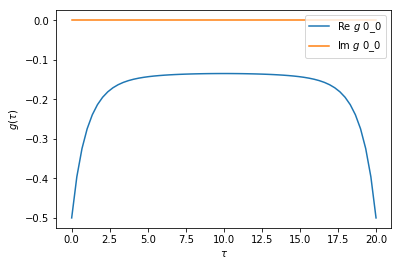

In [6]:
from pytriqs.gf import GfImTime
g_tau = GfImTime(name=r'$g$', beta=beta, statistic='Fermion', n_points=60, indices=[1])    
ed.set_g2_tau(g_tau, c(up,0), c_dag(up,0))

import matplotlib.pyplot as plt
from pytriqs.plot.mpl_interface import oplot
%matplotlib inline
plt.figure(); oplot(g_tau); plt.savefig('figure_g_tau.png')

100% |########################################################################|


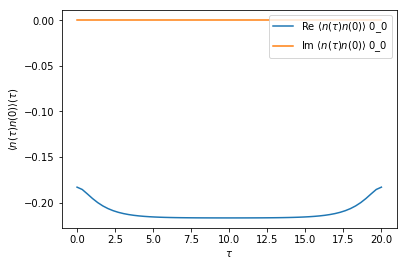

In [7]:
from pytriqs.gf import GfImTime
densdens_tau = GfImTime(name=r'$\langle n(\tau) n(0) \rangle$', beta=beta, statistic='Boson', n_points=60, indices=[1])    
ed.set_g2_tau(densdens_tau, n_up, n_down)

plt.figure(); oplot(densdens_tau); plt.savefig('figure_densdens_tau.png')

100% |########################################################################|


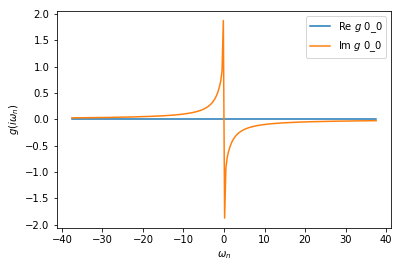

In [8]:
from pytriqs.gf import GfImFreq
g_iwn = GfImFreq(name=r'$g$', beta=beta, statistic='Fermion', n_points=120, indices=[1])
ed.set_g2_iwn(g_iwn, c(up,0), c_dag(up,0))

plt.figure(); oplot(g_iwn); plt.savefig('figure_g_iwn.png')

# Four-operator response functions

In [9]:
from pytriqs.gf import Gf
from pytriqs.gf import MeshImTime, MeshProduct

ntau = 21
imtime = MeshImTime(beta, 'Fermion', ntau)

In [10]:
prodmesh2 = MeshProduct(imtime, imtime)
g3pp_tau = Gf(name=r'$G^{(3)}(\tau_1, \tau_2)$', mesh=prodmesh2, target_shape=[1, 1, 1, 1])
ed.set_g3_tau(g3pp_tau, c(up,0), c_dag(up,0), c(up,0)*c_dag(up,0))

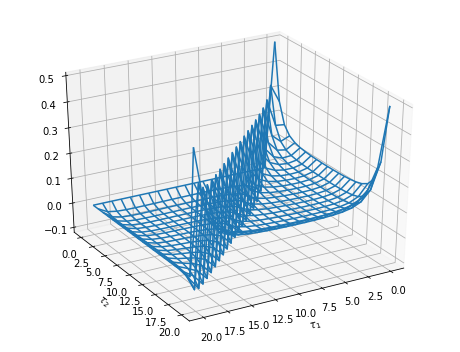

In [11]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(3.25*2, 2*2.5))
ax = fig.add_subplot(1,1,1, projection='3d')

data = g3pp_tau.data[:, :, 0, 0, 0, 0]
tau = [tau.real for tau in g3pp_tau.mesh.components[0]]
t1, t2 = np.meshgrid(tau, tau)
ax.plot_wireframe(t1, t2, data.real)
ax.view_init(30, 60)
ax.set_xlabel(r'$\tau_1$')
ax.set_ylabel(r'$\tau_2$')
plt.tight_layout()
plt.savefig('figure_g3pp_tau.png')

Text(54.01,0.5,'$\\tau_2$')

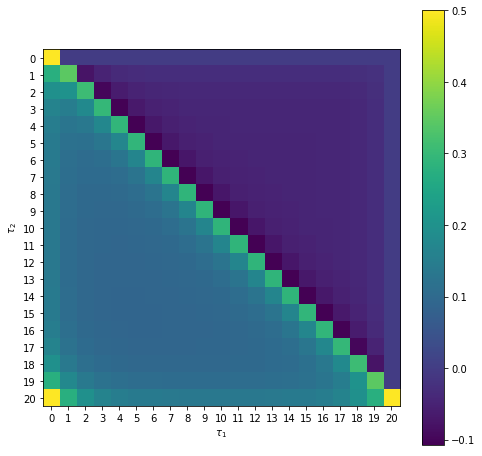

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(data.real)
plt.xticks(range(21))
plt.yticks(range(21))
plt.savefig('im_g3pp_tau.png')
plt.colorbar()
plt.xlabel(r'$\tau_1$')
plt.ylabel(r'$\tau_2$')